## Preface



First, install `CFEDemand` package if necessary:



In [1]:
!pip install CFEDemands --upgrade

Then load relevant dataset:



In [1]:
import cfe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Choose dataset ##
USE = "ICRISAT"
USE = "Tanzania"

# Results can be made persistent by saving them, and then re-loading...
if USE=="ICRISAT":
    DIR = "./IndianICRISAT/"
    r = cfe.from_dataset(DIR+'indian_icrisat.ds')
    USE_GOOD = 'Milk' #'Bengalgram dhal'
elif USE=="Tanzania":
    DIR = "./TanzanianNPS/"
    r = cfe.from_dataset(DIR+'tanzanian_nps.ds')
    USE_GOOD = 'Ripe Bananas'
else:
    raise ValueError("No such value of USE")

fct = pd.read_pickle(DIR+'fct.df')
rda = pd.read_pickle(DIR+"rda.df")

# Use prices, distribution of budgets from first round, first market:
t = r.firstround  # First round
m = r.coords['m'][0] # First market

# Distribution of predicted total expenditures
xhat = r.get_predicted_expenditures().sum('i')
xhat = xhat.where(xhat>0,np.nan)

# Note selection of prices for first period and first market
p = r.prices.sel(t=t,m=m).fillna(1).copy()

def my_prices(p0,p=p,i=USE_GOOD):
    p = p.copy()
    p.loc[i] = p0
    return p

# Now fix up FCT

# Change some labels in fct
d={'protein':'Protein',
   'protein g':'Protein',
   'fat':'Fat',
   'energy_kcal':'Calories',
   'energy kcal':'Calories',
   'calcium':'Calcium',
   'ca mg':'Calcium',
   'betacarotene':'Betacarotene',
   'thiamine':'Thiamine',
   'riboflavin':'Riboflavin',
   'niacin':'Niacin',
   'iron':'Iron',
   'fe mg':'Iron',
   'ascorbic_total':'Ascorbic Acid',
   'vit a ug':'Vitamin A',
   'vit b6 mg':'Vitamin B6',
   'vit b12 ug':'Vitamin B12',
   'vit d ug':'Vitamin D',
   'vit e ug':'Vitamin E',
   'vit c mg':'Vitamin C',
   'mg mg':'Magnesium',
   'zn mg':'Zinc'}

fct = fct.rename(columns=d) #[list(d.values())]

# Fix capitalization (to match food labels)
fct.index = fct.reset_index()['Item name'].str.title()

# Replace missing with zeros
fct = fct.fillna(0)

try:
    fct.index = fct.index.droplevel('unit')
except AttributeError: pass # No units?

def nutrient_demand(x,p,z=None):
    c = r.demands(x,p,z=z)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

# In first round, averaged over households and villages
zbar = r.z.sel(t=r.firstround).mean(['j','m'])[:-1] # Leave out log HSize

# This matrix product gives minimum nutrient requirements for average
# household in first round
hh_rda = rda.replace('',0).T@zbar

def nutrient_adequacy_ratio(x,p):
    return nutrient_demand(x,p)/hh_rda

## Simple Policy Experiments



Consider two policies:  First, changing income so that some proportion
of the population achieves nutritional adequacy.  Here choose quantile
we&rsquo;re interested in (e.g., a quantile of 0.5 is the median; a quantile
of 0.25 is the household at the 25th percentage point of the distribution).



In [1]:
# A quantile of 0.5 is the median.  Play with quantile value, or just assign.
x0 = xhat.sel(t=t,m=m).quantile(0.01,'j') # Budget (median household)
x0 = 50

# Out[56]:

# Out[57]:
# output
/home/ethanligon/Research/CFEDemands/cfe/root_with_precision.py:85: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -3.28E+04.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/home/ethanligon/Research/CFEDemands/cfe/root_with_precision.py:85: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -4.00E+00.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/home/ethanligon/Research/CFEDemands/cfe/root_with_precision.py:85: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -2.38E-07.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[

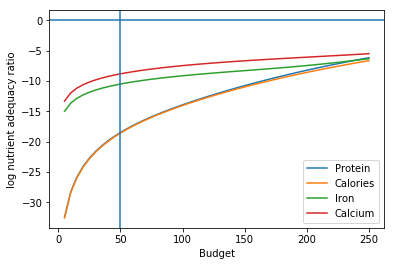

In [1]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(x0/10,x0*5,50)

UseNutrients = ['Protein','Calories','Iron','Calcium']
plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



# Out[39]:


# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

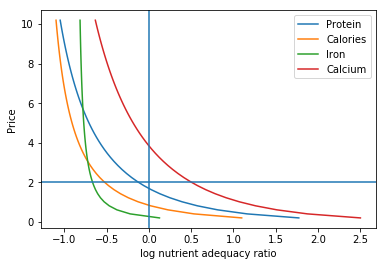

In [1]:
poorer_x = x0

# Choose reference (t,m) for reference good
ref_price = r.prices.sel(i=USE_GOOD,t=t,m=m)
P = np.linspace(ref_price/10,ref_price*5,50)

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(poorer_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.axhline(p.sel(i=USE_GOOD).values)

# Out[36]:


# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

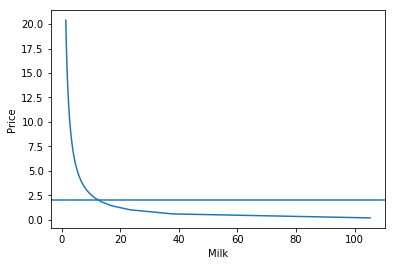

In [1]:
plt.plot([r.demands(poorer_x,my_prices(p0,i=USE_GOOD))[USE_GOOD] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(USE_GOOD)
plt.axhline(p.sel(i=USE_GOOD).values)

## Compensated Policy Experiments



# Out[45]:


# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

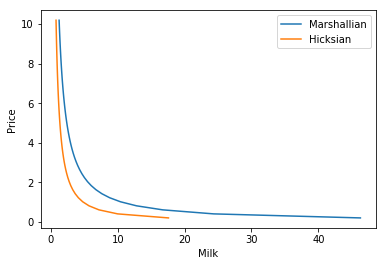

In [1]:
U0 = cfe.demands.marshallian.indirect_utility(x0,p,np.exp(r.alpha),r.beta,0)

plt.plot([r.demands(poorer_x,my_prices(p0,i=USE_GOOD))[USE_GOOD] for p0 in P],P)
plt.plot([r.demands(poorer_x,my_prices(p0,i=USE_GOOD),type="Hicksian")[USE_GOOD] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(USE_GOOD)
#plt.axhline(p.sel(i=USE_GOOD).values)
plt.legend(("Marshallian","Hicksian"))

In [1]:
def compensating_variation(U0,p0,p1):
    x0 = cfe.demands.hicksian.expenditurefunction(U0,p0,np.exp(r.alpha),r.beta,0)
    x1 =  cfe.demands.hicksian.expenditurefunction(U0,p1,np.exp(r.alpha),r.beta,0)

    return x1-x0

compensating_variation(U0,p,my_prices(1))